Data wrangling for the weather-airports project.

Part 1a: Weather events

Weather data: https://www.kaggle.com/sobhanmoosavi/us-weather-events

In [1]:
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pytz
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

In [2]:
START_YEAR = 2016
END_YEAR = 2019
START_TIME_LOCAL = 'StartTimeLocal'
END_TIME_LOCAL = 'EndTimeLocal'
START_OR_END = 'StartOrEnd'

save_data = True#; save_data = False #whether to save the resulting data
pd.options.mode.chained_assignment = None #turns off warnings for data replacements
showHistogram = True#; showHistogram = False

In [3]:
'''Data collection'''
stopwatch = TimeTracker.TimeTracker()
# Get all the data.
path = r'D:\Springboard_DataSci\Capstone_2\data'
os.chdir(path)
print('Importing weather events CSV file')
weather_events = pd.read_csv('US_WeatherEvents_2016-2019.csv', parse_dates=[3,4], infer_datetime_format=True)

Importing weather events CSV file


In [4]:
# Check for any duplicates.
nRows = len(weather_events.index)
weather_events.drop_duplicates(inplace=True)
print('Any duplicates dropped?', len(weather_events.index)!=nRows) #No duplicates.

Any duplicates dropped? False


## Data Analysis Strategy

To analyze the flights, we need to select our airports. Flights can be affected
by issues at either the departure airport or the arrival airport.

Let's think about the level of complexity that this could induce. Consider a
directed graph with N nodes and V vertices, where every node is connected in
both directions to every other node. The nodes represent the airports, and the
vertices represent flights between the airports. There are V(N) = N(N-1)
vertices in this graph. Here is a table of that function with N = 1, 2,..., 10:

N  V<br>
1  0<br>
2  2<br>
3  6<br>
4  12<br>
5  20<br>
6  30<br>
7  42<br>
8  56<br>
9  72<br>
10  90<br>

This scales up quickly! With over 25 million flights with which to work, perhaps
it is better to choose just a few airports and develop our model as a proof of concept.

There are a number of ways we could justify choosing our airports. We could take
the list of busiest airports and pick the top few. However, we would like to pick
airports that are not just busy but have different climates with different type of
weather events. For instance, northern states are more likely to get snowstorms in the
winter, southeastern states are more likely to get pop-up thunderstorms in the
summer, and western states are often unaffected by weather entirely. We also
need to keep the number of airports chosen low as discussed earlier. Finally,
we would like to choose airports that are major hubs and important international
gateways.

Based on these factors, we choose four airports:

(1) Atlanta: The world's busiest airport for years is home to Delta Airlines.
Air traffic there is occasionally disrupted by rain.

(2) New York-JFK: A hub for American and Delta Airlines and a major gateway
to Europe, JFK Airport routinely has to contend with snowstorms in the winter.

(3) Chicago O'Hare: The busiest airport in the region is also sometimes impacted
by winter weather. It has recently undergone a multi-billion-dollar makeover
that realigned many of its runways.

(4) Miami: Another American hub, Miami enjoys warm weather year-round, but
summertime storms are common. It is a gateway to South America.

In [5]:
AIRPORTS = ['ATL','JFK','ORD','MIA']
ICAO_codes = ('K'+pd.Series(AIRPORTS)).to_list()
Airport_names = ['Atlanta', 'JFK', 'O\'Hare', 'Miami']

In [6]:
'''Explore the weather data.'''
weather_ATL = weather_events[weather_events.AirportCode=='KATL']
weather_JFK = weather_events[weather_events.AirportCode=='KJFK']
weather_ORD = weather_events[weather_events.AirportCode=='KORD']
weather_MIA = weather_events[weather_events.AirportCode=='KMIA']

for i, airport in enumerate ([weather_ATL, weather_JFK, weather_ORD, weather_MIA]):
    print('\n' + Airport_names[i] + ' weather events:\n' + str(airport.Type.value_counts()))
    print(airport.Severity.value_counts())
    print('Latitude, Longitude:', airport.LocationLat.unique(), airport.LocationLng.unique())


Atlanta weather events:
Rain             2021
Fog               163
Precipitation      46
Snow               40
Hail                8
Storm               7
Name: Type, dtype: int64
Light       1510
Moderate     459
Heavy        136
Severe       126
UNK           46
Other          8
Name: Severity, dtype: int64
Latitude, Longitude: [33.6301] [-84.4418]

JFK weather events:
Rain             1690
Snow              249
Fog               211
Precipitation      26
Storm              15
Hail               14
Cold                3
Name: Type, dtype: int64
Light       1458
Moderate     426
Severe       183
Heavy        101
UNK           26
Other         14
Name: Severity, dtype: int64
Latitude, Longitude: [40.6392] [-73.7639]

O'Hare weather events:
Rain             1903
Snow              566
Fog               235
Precipitation      44
Hail               10
Storm               8
Cold                3
Name: Type, dtype: int64
Light       1859
Moderate     578
Severe       142
Heavy        136
U

All four airports' latitudes and longitudes check out.

In [7]:
# Keep only the airports that we need.
print(weather_events.iloc[0])

EventId                           W-1
Type                             Snow
Severity                        Light
StartTime(UTC)    2016-01-06 23:14:00
EndTime(UTC)      2016-01-07 00:34:00
TimeZone                  US/Mountain
AirportCode                      K04V
LocationLat                   38.0972
LocationLng                  -106.169
City                         Saguache
County                       Saguache
State                              CO
ZipCode                         81149
Name: 0, dtype: object


# Data cleaning

In [8]:
# The airport codes are in four-lettered codes, with K at the start of US airports.
weather_events = weather_events[weather_events.AirportCode.isin(ICAO_codes)]
print('No. of weather events at our airports:', len(weather_events)) #9773, down from over 5 million.

No. of weather events at our airports: 9773


Clean the data.

In [9]:
# Get rid of useless index.
weather_events.reset_index(drop=True, inplace=True)

# Drop useless columns.
weather_events = weather_events.loc[:, 'Type':'AirportCode']

In [10]:
# Convert datetimes and timezones to the right types of objects.
weather_events['StartTime(UTC)'] = weather_events['StartTime(UTC)'].dt.tz_localize('utc')
weather_events['EndTime(UTC)'] = weather_events['EndTime(UTC)'].dt.tz_localize('utc')
weather_events['TimeZone'] = weather_events['TimeZone'].map(pytz.timezone)

# Localize the times to their respective time zones.
print('Converting weather start times to local time zones')
weather_events[START_TIME_LOCAL] = weather_events.apply(
    lambda row: row['StartTime(UTC)'].tz_convert(row['TimeZone']), axis=1)
print('Converting weather end times to local time zones')
weather_events[END_TIME_LOCAL] = weather_events.apply(
    lambda row: row['EndTime(UTC)'].tz_convert(row['TimeZone']), axis=1)

Converting weather start times to local time zones
Converting weather end times to local time zones


In [11]:
# Recast the 4-lettered ICAO-code index into the 3-lettered IATA codes.
weather_events.rename(columns={'AirportCode': 'Airport'}, inplace=True)
weather_events.Airport = weather_events.Airport.apply(
    lambda prefix: prefix[1:])

# Drop useless columns.
weather_events = weather_events[['Airport',START_TIME_LOCAL,END_TIME_LOCAL,'Type','Severity']]

According to the paper which us-weather-events.csv is based on, Hail is "solid precipitation
including ice pellets and hail." This is a problem. Sleet rarely measures more than a couple
millimeters in diameter, but hail can grow up to several centimeters in diameter, making
takeoff and landing too dangerous. Unfortunately, the paper combines these two different types
of precipitation into one.

It also defines Storm as "the extremely windy condition, where the wind speed is at least
60kmh [sic]." That is about 40 mph. We need to rename "Storm" to "Wind".

In [12]:
weather_events['Type'].replace('Storm', 'Wind', inplace=True)

Let's see if we can discern between hail and sleet in our dataset. First, get a list of every
"hail" event and see what is immediately around it.

In [13]:
hail_events = weather_events[weather_events.Type=='Hail']
hailEventIndices = weather_events[weather_events.Type=='Hail'].index
n_hail = len(hailEventIndices)
print('Number of hail events:', n_hail)
assert hailEventIndices[0]!=0 and hailEventIndices[-1]!=len(hailEventIndices)-1,\
    'Very first or last event is hail, need to account for this'

Number of hail events: 32


In [14]:
# See how long before the first immediately prior and following events.
hail_prior_events = weather_events.loc[hailEventIndices-1].drop(START_TIME_LOCAL, axis=1) #drop for simplicity
hail_next_events = weather_events.loc[hailEventIndices+1].drop(END_TIME_LOCAL, axis=1) #drop for simplicity

In [15]:
# Some of these might be between different airports. Need to check this.
print('All events with hail codes have the same airport as their prior codes?',
      all([hail_events['Airport'].iloc[i] == hail_prior_events['Airport'].iloc[i] for i in range(n_hail)]))
print('All events with hail codes have the same airport as their following codes?',
      all([hail_events['Airport'].iloc[i] == hail_next_events['Airport'].iloc[i] for i in range(n_hail)]))


All events with hail codes have the same airport as their prior codes? True
All events with hail codes have the same airport as their following codes? True


Let's see if we can discern between hail and sleet in our dataset. First, get a list of every
"hail" event and see what is immediately around it.

In [16]:
# Good, no discrepancies. Next, let's check the time gaps.
hailStartTimeGap = pd.Series([hail_events[START_TIME_LOCAL].iloc[i]\
                              - hail_prior_events[END_TIME_LOCAL].iloc[i] for i in range(n_hail)])
hailEndTimeGap = pd.Series([hail_next_events[START_TIME_LOCAL].iloc[i]\
                            - hail_events[END_TIME_LOCAL].iloc[i] for i in range(n_hail)])
print('\nhailStartTimeGap values:\n' + str(hailStartTimeGap.value_counts().sort_index()))


hailStartTimeGap values:
0 days 00:00:00    26
0 days 00:04:00     1
0 days 01:20:00     1
0 days 05:25:00     1
0 days 21:41:00     1
2 days 13:41:00     1
4 days 18:58:00     1
dtype: int64


In [17]:
print('\nhailEndTimeGap values:\n' + str(hailEndTimeGap.value_counts().sort_index()))


hailEndTimeGap values:
0 days 00:00:00    29
0 days 00:04:00     1
0 days 03:54:00     1
1 days 10:07:00     1
dtype: int64


Most of "StartTimeGap" and nearly all of "EndTimeGap"s are 0. We need to make a decision
of when the cutoff will be for associating the current event with the next/prior one.

To start, let's sample just the ones with startTimeGaps and endTimeGaps of 0.

In [18]:
hours_StartTimeGap = hailStartTimeGap.apply(
    lambda x: timedelta.total_seconds(x)/3600)
hours_EndTimeGap = hailEndTimeGap.apply(
    lambda x: timedelta.total_seconds(x)/3600)
indeces_ZeroTimeGap = hours_StartTimeGap[hours_StartTimeGap==0].index.intersection(
    hours_EndTimeGap[hours_EndTimeGap==0].index)

In [19]:
hail_prior_events_ZeroTimeGap = hail_prior_events.iloc[indeces_ZeroTimeGap]
hail_next_events_ZeroTimeGap = hail_next_events.iloc[indeces_ZeroTimeGap]
print('\nPrior event codes with zero time gap:\n' + str(
    hail_prior_events.iloc[indeces_ZeroTimeGap]['Type'].value_counts()))
print('\nNext event codes with zero time gap:\n' + str(
    hail_next_events.iloc[indeces_ZeroTimeGap]['Type'].value_counts()))


Prior event codes with zero time gap:
Rain    17
Snow     7
Name: Type, dtype: int64

Next event codes with zero time gap:
Rain    19
Snow     5
Name: Type, dtype: int64


'''Most of the surrounding codes are Rain, but a few are Snow. This doesn't give us
any clear indication yet between sleet or hail.

However, we can make some assumptions. First, if the weather code immediately prior
or after is snow, this event marked "hail" is actually sleet. Let's start attempting
to classify what the Hail code actually means. To start, we populate that entire
column with NaN's, with our goal to accurately reduce them to zero. Assumptions
are listed below.'''

In [20]:
HAIL = 1
SLEET = 0
REM_NANS = 'Remaining unassigned Hail codes:'
AHC = 'ActualHailCode' #so I don't have to keep rewriting this

hailCodeNaNs = lambda df: df[AHC].isna().sum()

In [21]:
def histHailCount(df):
    month = df['Month']
    fig, ax = plt.subplots()
    ax.hist(month-0.5, bins=12, range=[0,12], align='right', color='r')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.set_title('Hail codes by month')
    plt.show()

Starting unassigned Hail codes: 32


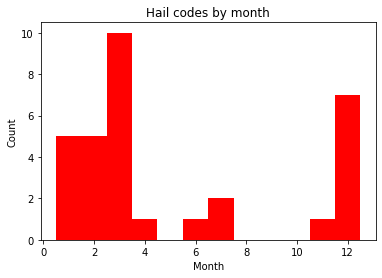

In [22]:
hail_events[AHC] = np.nan
hail_events['Month'] = hail_events[START_TIME_LOCAL].apply(lambda t: t.month)
print('Starting unassigned Hail codes:', hailCodeNaNs(hail_events)) #Starting count: 32
if showHistogram:
    histHailCount(hail_events[hail_events[AHC].isna()])

In [23]:
#1. Any Hail code in June, July, August, or September is probably hail.
hail_events[AHC][(hail_events['Month'] >= 6) & (hail_events['Month'] <= 9)] = HAIL
print(REM_NANS, hailCodeNaNs(hail_events)) #Remaining count: 198 (was 99; September excluded)
nAn_indeces = hail_events[hail_events[AHC].isna()].index

Remaining unassigned Hail codes: 29


In [24]:
#2. Any Hail code within six hours of a Snow code is probably sleet.
time_gap = 6
events_prior = hail_prior_events.loc[nAn_indeces - 1]
events_next = hail_next_events.loc[nAn_indeces + 1]
events_prior.set_index(events_prior.index + 1, inplace=True)
events_next.set_index(events_next.index - 1, inplace=True)

boolean_prior = (events_prior[END_TIME_LOCAL] + timedelta(hours=time_gap) >=\
    hail_events[hail_events[AHC].isna()][START_TIME_LOCAL]) &\
    (events_prior['Type'] == 'Snow')
boolean_next = (events_next[START_TIME_LOCAL] - timedelta(hours=time_gap) <=\
    hail_events[hail_events[AHC].isna()][END_TIME_LOCAL]) &\
    (events_next['Type'] == 'Snow')
hail_events[AHC].loc[(boolean_prior | boolean_next)\
                     [(boolean_prior | boolean_next)].index] = SLEET
print(REM_NANS, hailCodeNaNs(hail_events)) #Remaining count: 15

Remaining unassigned Hail codes: 15


In [25]:
#3. Any remaining Hail code in November, December, January, or February is probably sleet.
hail_events[AHC][hail_events[AHC].isna() & (
    (hail_events['Month'] >= 11) | (hail_events['Month'] <= 2))] = SLEET
print(REM_NANS, hailCodeNaNs(hail_events)) #Remaining count: 5
print('Airports and months of remaining unassigned hail codes:')
remaining_hail_unknowns = hail_events[hail_events[AHC].isna()][['Airport','Month']]
remaining_hail_unknowns_crosstab = pd.crosstab(
    index=remaining_hail_unknowns['Airport'], columns=remaining_hail_unknowns['Month'])
print(remaining_hail_unknowns_crosstab)

Remaining unassigned Hail codes: 5
Airports and months of remaining unassigned hail codes:
Month    3  4
Airport      
ATL      3  0
JFK      1  0
ORD      0  1


In [26]:
# Only 5 codes remain. Let's just look them up. Hail is a warm-weather event; sleet is a cold-weather event.
print(hail_events.loc[hail_events[AHC].isna(), ['Airport',START_TIME_LOCAL]])
hail_events.loc[1712, AHC] = SLEET # 35 degrees F
hail_events.loc[2481, AHC] = HAIL # 68F
hail_events.loc[5119, AHC] = SLEET # 47F
hail_events.loc[6195, AHC] = HAIL # 61F
hail_events.loc[6928, AHC] = HAIL # 57F

print('Remaining unassigned Hail codes:', hailCodeNaNs(hail_events))

     Airport             StartTimeLocal
1712     JFK  2019-03-10 06:19:00-04:00
2481     ORD  2016-04-25 22:29:00-05:00
5119     ATL  2016-03-03 13:28:00-05:00
6195     ATL  2018-03-20 00:23:00-04:00
6928     ATL  2019-03-25 20:20:00-04:00
Remaining unassigned Hail codes: 0


In [27]:
# Now let's set the correct codes to sleet.
weather_events.loc[hail_events[hail_events[AHC] == SLEET].index, 'Type'] = 'Sleet'
print(REM_NANS, hailCodeNaNs(hail_events))

Remaining unassigned Hail codes: 0


In [28]:
# All the hail codes are resolved. Remove the hail and other unneeded variables.
del(HAIL, SLEET, hailEndTimeGap, hailEventIndices, hailStartTimeGap, hail_events, hail_next_events,
    hail_next_events_ZeroTimeGap, hail_prior_events, hail_prior_events_ZeroTimeGap, hours_EndTimeGap,
    hours_StartTimeGap, indeces_ZeroTimeGap, nAn_indeces, nRows, n_hail, time_gap, ICAO_codes,
    weather_ATL, weather_JFK, weather_MIA, weather_ORD, boolean_next, boolean_prior, airport,
    events_next, events_prior, remaining_hail_unknowns, remaining_hail_unknowns_crosstab)

Investigate weather types and declare numeric variables for them.
Begin transitioning to the daily_weather DataFrame.

In [29]:
severity_value_counts = weather_events.Type.value_counts()
print(severity_value_counts)
if save_data:
    severity_value_counts.to_csv('severity_value_counts.csv')
for weatherType in weather_events.Type.unique():
    print('\nSeverities for weather type ' + weatherType + ':')
    print(weather_events[weather_events.Type==weatherType].Severity.value_counts())
print('\nSeverities for all types:\n', weather_events.Severity.value_counts())

Rain             7943
Snow              855
Fog               660
Precipitation     239
Wind               34
Sleet              26
Cold               10
Hail                6
Name: Type, dtype: int64

Severities for weather type Rain:
Light       5931
Moderate    1489
Heavy        523
Name: Severity, dtype: int64

Severities for weather type Fog:
Severe      452
Moderate    208
Name: Severity, dtype: int64

Severities for weather type Snow:
Light       602
Moderate    189
Heavy        64
Name: Severity, dtype: int64

Severities for weather type Precipitation:
UNK    239
Name: Severity, dtype: int64

Severities for weather type Sleet:
Other    26
Name: Severity, dtype: int64

Severities for weather type Wind:
Severe    34
Name: Severity, dtype: int64

Severities for weather type Cold:
Severe    10
Name: Severity, dtype: int64

Severities for weather type Hail:
Other    6
Name: Severity, dtype: int64

Severities for all types:
 Light       6533
Moderate    1886
Heavy        587
Severe  

## Weather codes

Rain: Light, Moderate, Heavy<br>
Fog: Moderate, Severe<br>
Snow: Light, Moderate, Heavy<br>
Precipitation: UNK (we need to fix this)<br>
Hail: Other<br>
Sleet: Other<br>
Storm: Severe<br>
Cold: Severe<br>

In [30]:
DF_width = len(weather_events.columns) #get this now before new columns added
weather_events['HailCode'] = (weather_events.Type == 'Hail').map(int)
weather_events['SleetCode'] = (weather_events.Type == 'Sleet').map(int)
weather_events['HiWindCode'] = (weather_events.Type == 'Wind').map(int) #See later
weather_events['ColdCode'] = (weather_events.Type == 'Cold').map(int)

In [31]:
LightModerateHeavy = {'Light':1, 'Moderate':2, 'Heavy':3}
weather_events['RainCode'] =\
    weather_events[weather_events.Type=='Rain'].Severity.map(LightModerateHeavy)
weather_events.RainCode = weather_events.RainCode.fillna(value=0)
weather_events['FogCode'] =\
    weather_events[weather_events.Type=='Fog'].Severity.map({'Moderate':1, 'Severe':2})
weather_events.FogCode = weather_events.FogCode.fillna(value=0)
weather_events['SnowCode'] =\
    weather_events[weather_events.Type=='Snow'].Severity.map(LightModerateHeavy)
weather_events.SnowCode = weather_events.SnowCode.fillna(value=0)
FIRST_WEATHER_CODE = (weather_events.columns)[DF_width] #needed later

In [32]:
#Fix the "Precipitation" and "UNK" entries.
PRECIP = 'Precipitation'; UNK = 'UNK'
print('Count of "' + PRECIP + '" XOR "' + UNK + ':"', len(weather_events\
    [((weather_events.Type == PRECIP) &
      (weather_events.Severity != UNK)) |
      ((weather_events.Type != PRECIP) &
      (weather_events.Severity == UNK))].index)) #Perfect match

Count of "Precipitation" XOR "UNK:" 0


In [33]:
print('\nImputing these events')
for airport in AIRPORTS:
    airport_indeces = weather_events[weather_events.Airport == airport].index
    if airport_indeces.size > 0:
        assert np.max(np.diff(airport_indeces)) == 1,\
            'Indexes misaligned for ' + str(airport)
        weather_current_airport = weather_events.loc[airport_indeces]
        unknown_precip_indeces = weather_current_airport\
            [weather_current_airport.Type == PRECIP].index
        if len(unknown_precip_indeces)==0:
            print(airport, 'has no unknown precipitation')
        else:
            weather_before_indeces = unknown_precip_indeces-1
            weather_after_indeces = unknown_precip_indeces+1
            try:
                weather_current_airport.loc[weather_before_indeces[0]]
            except KeyError:
                raise ValueError('First weather event at', airport, 'is unknown precip')
            try:
                weather_current_airport.loc[weather_after_indeces[-1]]
            except KeyError:
                raise ValueError('Last weather event at', airport, 'is unknown precip')
            # Will need to code a workaround if either of these issues arise.
        
            # Impute based on averages from entries immediately before and after.
            # Round up decimals to nearest integer.
            imputation_values = np.ceil((
                weather_current_airport.loc[weather_before_indeces, FIRST_WEATHER_CODE:].values
                + weather_current_airport.loc[weather_after_indeces, FIRST_WEATHER_CODE:].values)/2).astype(int)
            for i, index in enumerate(unknown_precip_indeces):
                weather_events.loc[index, FIRST_WEATHER_CODE:] = imputation_values[i]
    else:
        print(airport, 'has no entries')


Imputing these events


In [34]:
print(weather_events.columns)
weather_events.drop(['Type', 'Severity'], axis=1, inplace=True)

Index(['Airport', 'StartTimeLocal', 'EndTimeLocal', 'Type', 'Severity',
       'HailCode', 'SleetCode', 'HiWindCode', 'ColdCode', 'RainCode',
       'FogCode', 'SnowCode'],
      dtype='object')


Weather events' impacts on flights do not end the moment the weather does. This is particularly
a problem for snow, which does not run off like rain does. The remedy for this in our database
is simple: Extend the length of the weather events.

How long to extend each event is probably a project in its own right. For now, we will use the following:<br>
Light snow: Lasts 1 hour after the event<br>
Moderate snow: Lasts 2 hours after<br>
Heavy snow: Lasts 6 hours<br>
All other events: Lasts 15 minutes

Snow: Begins 2 hours before the event<br>
All others: Begins 15 minutes before

In [35]:
def adjust_time(row):
    row[START_TIME_LOCAL] -= timedelta(minutes=[15, 60][row.SnowCode > 0])
    row[END_TIME_LOCAL] += timedelta(hours=[1/2, 1, 2, 6][int(row.SnowCode)])
    return row

In [36]:
print('Extending weather events')
weather_events = weather_events.apply(
    lambda row: adjust_time(row), axis=1)

Extending weather events


Now we need to build timelines of each weather event. To start, we split up the dataframe by event type,
then melt the dataframes on the airports and appropriate weather codes.

In [37]:
airport_start_end = weather_events.loc[:, :END_TIME_LOCAL]
events_rain = pd.concat([airport_start_end, pd.DataFrame(weather_events.RainCode)], axis=1)[weather_events.RainCode > 0]
events_sleet = pd.concat([airport_start_end, pd.DataFrame(weather_events.SleetCode)], axis=1)[weather_events.SleetCode > 0]
events_wind = pd.concat([airport_start_end, pd.DataFrame(weather_events.HiWindCode)], axis=1)[weather_events.HiWindCode > 0]
events_cold = pd.concat([airport_start_end, pd.DataFrame(weather_events.ColdCode)], axis=1)[weather_events.ColdCode > 0]
events_fog = pd.concat([airport_start_end, pd.DataFrame(weather_events.FogCode)], axis=1)[weather_events.FogCode > 0]
events_snow = pd.concat([airport_start_end, pd.DataFrame(weather_events.SnowCode)], axis=1)[weather_events.SnowCode > 0]
events_hail = pd.concat([airport_start_end, pd.DataFrame(weather_events.HailCode)], axis=1)[weather_events.HailCode > 0]

sort_events = lambda df: df.sort_values(by=['Airport', 'Time']).reset_index(drop=True)

events_cold = sort_events(pd.melt(events_cold, id_vars=['Airport', 'ColdCode'], var_name=START_OR_END, value_name='Time'))
events_fog = sort_events(pd.melt(events_fog, id_vars=['Airport', 'FogCode'], var_name=START_OR_END, value_name='Time'))
events_hail = sort_events(pd.melt(events_hail, id_vars=['Airport', 'HailCode'], var_name=START_OR_END, value_name='Time'))
events_rain = sort_events(pd.melt(events_rain, id_vars=['Airport', 'RainCode'], var_name=START_OR_END, value_name='Time'))
events_sleet = sort_events(pd.melt(events_sleet, id_vars=['Airport', 'SleetCode'], var_name=START_OR_END, value_name='Time'))
events_snow = sort_events(pd.melt(events_snow, id_vars=['Airport', 'SnowCode'], var_name=START_OR_END, value_name='Time'))
events_wind = sort_events(pd.melt(events_wind, id_vars=['Airport', 'HiWindCode'], var_name=START_OR_END, value_name='Time'))

For the binary codes--Cold, hail, sleet, and wind--the start and end times should alternate. Remove any code that doesn't.

In [38]:
'''Removes any consecutive and overlap codes (latter for start codes, former for end codes), and promote any
overlapping codes to the higher code. Input df is assumed to be sorted by Airport and then Time.'''
def remove_overlaps(df, code_column=1):
    assert set(df[START_OR_END].unique()) == {START_TIME_LOCAL, END_TIME_LOCAL},\
        START_OR_END + ' column contains ' + str(set(df[START_OR_END].unique()))\
            + ', should only contain ' + str({START_TIME_LOCAL, END_TIME_LOCAL})
    top_code = int(max(df.iloc[:, code_column]))
    print('Attempting to balance on', df.columns[code_column])
    
    '''Combine consecutive codes with the same start/end and intensity values into one.'''
    def combine_same_codes(df, code_column):
        rows_to_drop = []
        nrows = df.shape[0]
        while True:
            for code in range(1, top_code+1):
                current_df = df[df.iloc[:, code_column] == code] #same code
                for airport in (current_df.Airport.unique()):
                    specific_df = current_df[current_df.Airport == airport] #same code and airport
                    rows_waiting = 0
                    for i in range(len(specific_df)):
                        row_name = specific_df.iloc[i].name
                        if specific_df[START_OR_END].iloc[i] == START_TIME_LOCAL:
                            rows_waiting += 1 #We have an unresolved StartTimeLocal
                            if rows_waiting > 1:
                                rows_to_drop.append(row_name)
                        else: #EndTimeLocal
                            if rows_waiting > 1: #We have an unresolved EndTimeLocal
                                rows_to_drop.append(row_name)
                            rows_waiting -= 1
            if nrows == df.shape[0]:
                break
            nrows = df.shape[0]
        return sort_events(df.drop(index=rows_to_drop))
        return sort_events(df.loc[:, :'Time'].drop(index=rows_to_drop))
    
    '''Move any lower code that is "hidden" by a higher code. For example, if a 1 code spans 5 AM - 7 AM,
    and a 2 code spans 4 AM - 6 AM, the 1 code is set to start at 6:00:01 AM.'''
    def move_embedded_codes(df, code_column):
        ONES_LIVE = '1sLive'; TWOS_LIVE = '2sLive'; THREES_LIVE = '3sLive'
        df[ONES_LIVE] = df[TWOS_LIVE] = df[THREES_LIVE] = 0
        for i in range(len(df)):
            current_code = int(df.iloc[i, code_column])
            # Calculate whether the code is balanced (0) or not (1)
            if df[START_OR_END].iloc[i] == START_TIME_LOCAL:
                df[[ONES_LIVE, TWOS_LIVE, THREES_LIVE][current_code-1]].iloc[i] += 1
            else:
                df[[ONES_LIVE, TWOS_LIVE, THREES_LIVE][current_code-1]].iloc[i] -= 1
            if i>0: # Creates cumulative sums
                df.loc[i, [ONES_LIVE, TWOS_LIVE, THREES_LIVE]] = df.loc[i, [ONES_LIVE, TWOS_LIVE, THREES_LIVE]] +\
                    df.loc[i-1, [ONES_LIVE, TWOS_LIVE, THREES_LIVE]]
                    
        for i in range(1, len(df)):
            if df[START_OR_END].iloc[i] == END_TIME_LOCAL:
                # A 2 ends, exposing an unresolved 1 (3 must not be live)
                if all(df.loc[i-1, [ONES_LIVE, TWOS_LIVE, THREES_LIVE]] == [1, 1, 0])\
                and all(df.loc[i, [ONES_LIVE, TWOS_LIVE, THREES_LIVE]] == [1, 0, 0]):
                    # Search backwards until we find a start code 1
                    j = i-1
                    while True:
                        if df.iloc[j, code_column] == 1:
                            break
                        j -= 1
                    # Move this 1 code start time to just after the 2 code end time
                    df.loc[j, 'Time'] = df.loc[i, 'Time'] + timedelta(seconds=1)
                
                # A 3 ends, exposing an unresolved 2
                elif all(df.loc[i-1, [TWOS_LIVE, THREES_LIVE]] == [1, 1])\
                and all(df.loc[i, [TWOS_LIVE, THREES_LIVE]] == [1, 0]):
                    # Search backwards until we find a start code 1
                    j = i-1
                    while True:
                        if df.iloc[j, code_column] == 2:
                            break
                        j -= 1
                    # Move this 2 code start time to just after the 3 code end time
                    df.loc[j, 'Time'] = df.loc[i, 'Time'] + timedelta(seconds=2)
                
                # A 3 ends, exposing an unresolved 1 (2 must not be live)
                elif all(df.loc[i-1, [ONES_LIVE, TWOS_LIVE, THREES_LIVE]] == [1, 0, 1])\
                and all(df.loc[i, [ONES_LIVE, TWOS_LIVE, THREES_LIVE]] == [1, 0, 0]):
                    # Search backwards until we find a start code 1
                    j = i-1
                    while True:
                        if df.iloc[j, code_column] == 1:
                            break
                        j -= 1
                    # Move this 1 code start time to just after the 3 code end time
                    df.loc[j, 'Time'] = df.loc[i, 'Time'] + timedelta(seconds=1)

                # A 2 ends while a 3 is still live, and the 2 started before the 3
                if all(df.loc[i-1, [TWOS_LIVE, THREES_LIVE]] == [1, 1])\
                and all(df.loc[i, [TWOS_LIVE, THREES_LIVE]] == [0, 1]):      
                    j = i-1
                    starting_index = None
                    while True:
                        if df.iloc[j, code_column] == 3:
                            starting_index = j
                            break
                        if df.iloc[j, code_column] == 2:
                            break
                        j -= 1
                    # Move this 2 code end time to just before the 3 code end time
                    if starting_index != None:
                        df.loc[i, 'Time'] = df.loc[starting_index, 'Time'] - timedelta(seconds=2)

                # A 1 ends while a 2 is still live, and the 1 started before the 2
                elif all(df.loc[i-1, [ONES_LIVE, TWOS_LIVE]] == [1, 1])\
                and all(df.loc[i, [ONES_LIVE, TWOS_LIVE]] == [0, 1]):
                    j = i-1
                    starting_index = None
                    while True:
                        if df.iloc[j, code_column] == 2:
                            starting_index = j
                            break
                        if df.iloc[j, code_column] == 1:
                            break
                        j -= 1
                    # Move this 1 code end time to just before the 2 code end time
                    if starting_index != None:
                        df.loc[i, 'Time'] = df.loc[starting_index, 'Time'] - timedelta(seconds=1)

                # A 1 ends while a 3 is still live, and the 1 started before the 3
                elif all(df.loc[i-1, [ONES_LIVE, THREES_LIVE]] == [1, 1])\
                and all(df.loc[i, [ONES_LIVE, THREES_LIVE]] == [0, 1]):
                    j = i-1
                    starting_index = None
                    while True:
                        if df.iloc[j, code_column] == 3:
                            starting_index = j
                            break
                        if df.iloc[j, code_column] == 1:
                            break
                        j -= 1
                    # Move this 1 code end time to just before the 3 code end time
                    if starting_index != None:
                        df.loc[i, 'Time'] = df.loc[starting_index, 'Time'] - timedelta(seconds=1)
                
        return sort_events(df.loc[:, :'Time'])
    
    '''Promote concurrent codes to the higher one.'''
    def promote_codes(df, code_column):
        '''Increase or decrease the counter depending on whether the time is a StartTime or EndTime.'''
        def counter_update(df, code_column, counter, value):
            if df.iloc[i, code_column] == value:
                if df.loc[i, START_OR_END] == START_TIME_LOCAL:
                    return counter + 1
                return counter - 1
            return counter
        
        twos_live = threes_live = 0
        for i in range(len(df)):
            current_value = df.iloc[i, code_column]
            if current_value == 3:
                threes_live = counter_update(df, code_column, threes_live, 3)
            elif current_value == 2:
                if threes_live > 0:
                    df.iloc[i, code_column] = 3
                else:
                    twos_live = counter_update(df, code_column, twos_live, 2)
            else:
                if threes_live > 0:
                    df.iloc[i, code_column] = 3
                elif twos_live > 0:
                    df.iloc[i, code_column] = 2
        return df
    
    # Step 1: Combine events within the same code.
    df = combine_same_codes(df, code_column)

    if top_code > 1: # No embedded codes if only 1-codes exist
        attempts = 1
        # Step 2: Deal with overlaps if necessary. This may take several passes.
        while True:
            print('  Embedding attempts:', attempts)
            df_updated = move_embedded_codes(df.copy(), code_column)
            if df.equals(df_updated):
                break
            attempts += 1
            df = df_updated

        # Step 3: Promote embedded lower codes.
        df = promote_codes(df, code_column)
        
        # Step 4: Do one more round of cleanup.
        df = combine_same_codes(df, code_column)
    return df

In [39]:
# Balance the 1-code sets (this is purely for completeness; they are already balanced)
events_cold = remove_overlaps(events_cold.reset_index(drop=True))
events_hail = remove_overlaps(events_hail.reset_index(drop=True))
events_sleet = remove_overlaps(events_sleet.reset_index(drop=True))
events_wind = remove_overlaps(events_wind.reset_index(drop=True))

Attempting to balance on ColdCode
Attempting to balance on HailCode
Attempting to balance on SleetCode
Attempting to balance on HiWindCode


In [40]:
# Balance the 2-code set
events_fog = remove_overlaps(events_fog.reset_index(drop=True))

Attempting to balance on FogCode
  Embedding attempts: 1
  Embedding attempts: 2


In [41]:
# Balance the 3-code sets
events_snow = remove_overlaps(events_snow.reset_index(drop=True))

Attempting to balance on SnowCode
  Embedding attempts: 1
  Embedding attempts: 2
  Embedding attempts: 3


In [42]:
events_rain = remove_overlaps(events_rain.reset_index(drop=True)) #takes awhile

Attempting to balance on RainCode
  Embedding attempts: 1
  Embedding attempts: 2
  Embedding attempts: 3


In [43]:
# Save the balanced weather codes
if save_data:
    print('Saving data')
    events_cold.to_csv('events_cold.csv', index=False)
    events_hail.to_csv('events_hail.csv', index=False)
    events_sleet.to_csv('events_sleet.csv', index=False)
    events_wind.to_csv('events_wind.csv', index=False)
    events_fog.to_csv('events_fog.csv', index=False)
    events_snow.to_csv('events_snow.csv', index=False)
    events_rain.to_csv('events_rain.csv', index=False)

Saving data


In [44]:
print('Total runtime:', stopwatch.getElapsedTime())

Total runtime: --- 5.18 minutes ---
